# Waveguide Attenuation

Calculate the attenuation constant of a WR2.8 waveguide.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.constants as sc

from numpy import sqrt, pi, log10, arctan
from numpy import log as ln
from scipy.constants import nano, micro, giga, mu_0, c, e

# RF-tools
# to install, see: 
# https://github.com/garrettj403/RF-tools
import rftools as rf
from rftools.misc import conductivity_4k, conductivity_rough

# SciencePlots
# to install, see:
# https://github.com/garrettj403/SciencePlots
plt.style.use(['science', 'notebook'])

In [2]:
# Frequency sweep
freq = np.arange(250, 400.1) * giga

# Array index at 320 GHz (middle of band)
idx = np.abs(freq - 320 * giga).argmin()

### Waveguide Dimensions

In [3]:
a = 700 * micro
b = 350 * micro

In [4]:
# Build waveguide using RF-tools
wg = rf.RectangularWaveguide(a, b, verbose=False)

# Attenuation at room temperature (300 K)

### Conductivity at 300 K

- For conductivity values see:
   - J. W. Lamb, "Miscellaneous data on materials for millimetre and submillimetre optics," Int. J. Infrared Millimeter Waves, vol. 17, no. 12, pp. 1997–2034, Dec. 1996. (Table 8)
   - R. Finger, “Gold plated brass annealing trials and annealed C101 copper residual resistivity ratio,” 2008.

In [5]:
# Conductivity values from the literature (300K, smooth surface)
cond_cu = 5.9e7  # S/m, from Finger 2008
cond_au = 2.1e7  # S/m, from Lamb 1996
cond_al = 1.6e7  # S/m, from Lamb 1996

### Effective conductivity of the rough waveguide walls

- Using the Hammerstad-Bekkadal (HB) formula:
$$\sigma_\mathrm{rough} = \sigma\left\{1 + \dfrac{2}{\pi}\arctan\left[1.4\left(\dfrac{h}{\delta}\right)^2\right]\right\}^{-2}$$

In [6]:
# RMS surface roughness
h = 75 * nano

In [7]:
# Conductivity (300K, rough surface)
cond_rough_cu = conductivity_rough(freq, cond_cu, h)
cond_rough_au = conductivity_rough(freq, cond_au, h)
cond_rough_al = conductivity_rough(freq, cond_al, h)

### Waveguide attenuation at 300 K with rough walls

- For equation, see pg. 630 in:
   - E. Maxwell, “Conductivity of Metallic Surfaces at Microwave Frequencies,” J. Appl. Phys., vol. 18, no. 7, pp. 629–638, Jul. 1947.

- Attenuation in Np/m:
$$\alpha = \dfrac{1}{2b}\cdot\dfrac{1}{\sqrt{1 - (\lambda_0/\lambda_c)^2}}\cdot\sqrt{\dfrac{4\pi}{\lambda_0\mu c\sigma}}\cdot\left[1 + \dfrac{2b}{a}\left(\dfrac{\lambda_0}{\lambda_c}\right)^2\right]$$

- I've found that this model matches HFSS very well.

In [8]:
# Np/m -> dB/m
k = 20 / ln(10)

# Calculate waveguide attenuation (300K, rough surface)
att_cu = k * wg.attenuation(freq, cond_rough_cu)
att_au = k * wg.attenuation(freq, cond_rough_au)
att_al = k * wg.attenuation(freq, cond_rough_al)

print("Attenuation at 320 GHz:")
print(" - Cu: {:.2f} dB/m".format(att_cu[idx]))
print(" - Au: {:.2f} dB/m".format(att_au[idx]))
print(" - Al: {:.2f} dB/m".format(att_al[idx]))

Attenuation at 320 GHz:
 - Cu: 25.13 dB/m
 - Au: 35.61 dB/m
 - Al: 39.69 dB/m


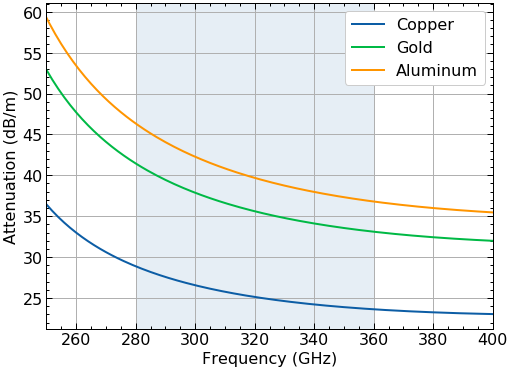

In [9]:
# Plot waveguide attenuation (300K, rough surface)
fig, ax = plt.subplots()
plt.plot(freq / giga, att_cu, label='Copper')
plt.plot(freq / giga, att_au, label='Gold')
plt.plot(freq / giga, att_al, label='Aluminum')
plt.axvspan(280, 360, alpha=0.1)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Attenuation (dB/m)")
plt.xlim([freq.min() / giga, freq.max() / giga])
ax.legend(frameon=True, framealpha=1)
ax.grid();

As expected, copper provides the lowest loss.

# Attenuation at 4K

### Conductivity at 4K

- See:
   - R. Finger and A. R. Kerr, “Microwave Loss Reduction in Cryogenically Cooled Conductors,” Int. J. Infrared Millimeter Waves, vol. 29, no. 10, pp. 924–932, Oct. 2008.

- Conductivity in the anomalous skin effect regime:
$$\sigma_\mathrm{eff} = \left(\dfrac{n_e^2e^4}{\pi\mu m^2V_f^2f}\right)^\frac{1}{3}$$

In [10]:
# Material properties from Ashcroft & Mermin

# Fermi velocity
vf_cu = 1.57e6  # m/s
vf_au = 1.40e6  # m/s
vf_al = 2.03e6  # m/s

# Electron density
ne_cu =  8.47e28  # 1/m3
ne_au =  5.90e28  # 1/m3
ne_al = 18.10e28  # 1/m3

In [11]:
# Conductivity (4K, smooth surface)
cond_4k_cu = conductivity_4k(freq, vf_cu, ne_cu)
cond_4k_au = conductivity_4k(freq, vf_au, ne_au)
cond_4k_al = conductivity_4k(freq, vf_al, ne_al)

### Effective conductivity of rough waveguide walls

- Using Hammerstad-Bekkadal (HB) formula:
$$\sigma_\mathrm{rough} = \sigma\left\{1 + \dfrac{2}{\pi}\arctan\left[1.4\left(\dfrac{h}{\delta}\right)^2\right]\right\}^{-2}$$

In [12]:
# Conductivity (4K, rough surface)
cond_4k_rough_cu = conductivity_rough(freq, cond_4k_cu, h)
cond_4k_rough_au = conductivity_rough(freq, cond_4k_au, h)
cond_4k_rough_al = conductivity_rough(freq, cond_4k_al, h)

### Waveguide attenuation at 4K

In [13]:
# Calculate waveguide attenuation (4K, rough surface)
att4k_cu = k * wg.attenuation(freq, cond_4k_rough_cu)
att4k_au = k * wg.attenuation(freq, cond_4k_rough_au)
att4k_al = k * wg.attenuation(freq, cond_4k_rough_al)

print("Attenuation at 320 GHz:")
print(" - Cu: {:.2f} dB/m".format(att4k_cu[idx]))
print(" - Au: {:.2f} dB/m".format(att4k_au[idx]))
print(" - Al: {:.2f} dB/m".format(att4k_al[idx]))

Attenuation at 320 GHz:
 - Cu: 20.38 dB/m
 - Au: 21.39 dB/m
 - Al: 18.33 dB/m


**Note:** This model for waveguide attenuation might not work in the anomalous skin effect regime!

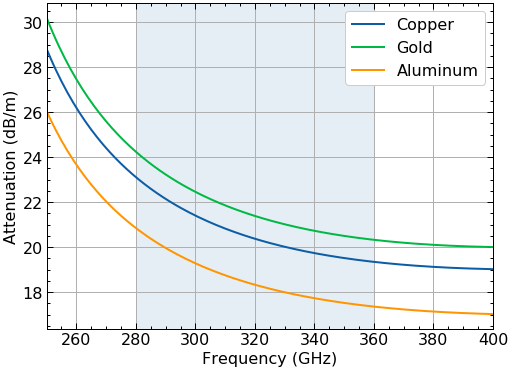

In [14]:
# Plot waveguide attenuation (4K, rough surface)
fig, ax = plt.subplots()
plt.plot(freq / giga, att4k_cu, label='Copper')
plt.plot(freq / giga, att4k_au, label='Gold')
plt.plot(freq / giga, att4k_al, label='Aluminum')
plt.axvspan(280, 360, alpha=0.1)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Attenuation (dB/m)")
plt.xlim([freq.min() / giga, freq.max() / giga])
ax.legend(frameon=True, framealpha=1)
ax.grid();

**Note:** Aluminum provides the lowest loss!